In [1]:
!pip install opendatasets

In [2]:
import opendatasets as od

od.download(
    "https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: tahaebrahim
Your Kaggle Key: ········


100%|██████████| 25.7M/25.7M [00:14<00:00, 1.80MB/s]


# <font color='orange'>***1. Download dependencies***</font>

In [3]:
!pip install contractions

In [4]:
import nltk

In [5]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


True

# <font color='orange'>***2. Import necessary libraries***</font>

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import contractions
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pickle
import io
from sklearn.metrics import confusion_matrix
from imblearn.metrics import sensitivity_specificity_support
from sklearn.metrics import classification_report
import seaborn as sn

# <font color='orange'>***3. Read the dataset***</font>

In [15]:
# The datset directory
dataset_path = "./imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv"
# Read the dataset in DataFrame
dataset_df = pd.read_csv(dataset_path)
# Show Random sample of data
dataset_df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [16]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


# <font color='orange'>***4. Cleaning and preprocessing***</font>

In [17]:
# Remove nan entries
proc_dateset= dataset_df.dropna()
# Remove duplications in reviews and their coresponding sentiment
proc_dateset = dataset_df.drop_duplicates(subset=['review'])
# Reste the indicies
proc_dateset.reset_index(drop=True, inplace=True)

In [18]:
proc_dateset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49582 entries, 0 to 49581
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     49582 non-null  object
 1   sentiment  49582 non-null  object
dtypes: object(2)
memory usage: 774.8+ KB


**Text Cleaning**

In [19]:
# Get english stop words (most frequent)
stop_words = stopwords.words('english')
# Get WordNetLemmatizer to get the context of words
lemmatizer = WordNetLemmatizer()

In [20]:
# Expand contractions for better Text interpretations and stop words removal
def expand_contractions(text):
    # creating an empty list
    expanded_words1 = []
    for word in text.split():
      # using contractions.fix to expand the shortened words
      expanded_words1.append(contractions.fix(word))

    text = ' '.join(expanded_words1)

    contractions_dict = {
        "'m": " am",
        "'s": " is",
        "'re": " are",
        "'ve": " have",
        "'ll": " will",
        "'d": " would",
    }

    # Case-insensitive flag for the regular expression
    pattern = re.compile(r"\b(" + "|".join(re.escape(key) for key in contractions_dict.keys()) + r")\b", re.IGNORECASE)

    # Replace contractions with their expanded forms
    expanded_text = pattern.sub(lambda match: contractions_dict[match.group(0).lower()], text)

    return expanded_text

In [21]:
text = """
Yahya's playing football.I haven't seen Mary, but I'm sure she'll be at the party.
She's not the only one who won't come.
They're going to the store, aren't they?. Yahya ain't good boy
"""
print('Original Text: ',text)
print()
print('Expanded text:\n',expand_contractions(text))

Original Text:  
Yahya's playing football.I haven't seen Mary, but I'm sure she'll be at the party.
She's not the only one who won't come.
They're going to the store, aren't they?. Yahya ain't good boy


Expanded text:
 Yahya is playing football.I have not seen Mary, but I am sure she will be at the party. She is not the only one who will not come. They are going to the store, are not they?. Yahya are not good boy


In [22]:
# Remove stop words to reduce the dimensionality size and improve total performance
def stopWordsRemoval(sentence):
    filtered_sentence = []
    # Tokenize the sentence
    sentence =  word_tokenize(sentence)
    for w in sentence:
        if w not in stop_words:
            # Only append non stop words
            filtered_sentence.append(w)

    return ' '.join(filtered_sentence)

In [23]:
text = """
Yahya is a good boy.
Soliman and Taha love ML.
Gamal or Fatma were playing an yoga.
"""
print('Original Text: ',text)
print()
print('After stop wors removal:\n',stopWordsRemoval(text))

Original Text:  
Yahya is a good boy.
Soliman and Taha love ML.
Gamal or Fatma were playing an yoga.


After stop wors removal:
 Yahya good boy . Soliman Taha love ML . Gamal Fatma playing yoga .


In [24]:
# This function will be used to help in lemmatization to get pos tag
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [25]:
# For lemmatization (Lemmatization is similar to stemming but it brings context to the words)
def lemmatization(sentence):
    filtered_sentence = []
    sentence = word_tokenize(sentence)
    sentence = pos_tag(sentence)
    tokenCount = len(sentence)
    for i in range (0, tokenCount):
        t = sentence[i][0] # The token
        p = sentence[i][1] # The pos tag
        p = get_wordnet_pos(p)
        l = lemmatizer.lemmatize(t, pos = p)
        filtered_sentence.append(l)

    return ' '.join(filtered_sentence)

In [26]:
lemmatization('is are playing saw had')

'be be play saw have'

**Final preprocessin and cleaning function**

In [27]:
def text_preprocessing(text):
    # Matches Twitter handles.
    text = re.sub("(@[A-Za-z0-9]+)", " ",text)

    # Matches URLs.
    text = re.sub("(\w+:\/\/\S+)", " ",text)

    # Matches Hashtags
    text = re.sub(r'#\w*', ' ' , text)

    # Expand contradictions
    text = expand_contractions(text)

    # Convert text to lowercase
    text = text.lower()

    # Remove stop words like are, is, has ...
    text = stopWordsRemoval(text)

    # Lemmatization brings context to the words
    text = lemmatization(text)

    # Matches special characters letters, spaces, and tabs.
    text = re.sub("([^A-Za-z \t])", " ",text)

    # Remove extra white spaces
    text = " ".join(text.split())

    return text

In [28]:
text = """
Yahya's playing football. I'd played too much.
I'm love 😂🤣❤😘👀 my wife.
I haven't seen Mary, but I'm sure she'll be at the party.
he visit https://www.google.com/ too much.
#BFCAI #CS
@Soliman @Fatma @Gamal @Taha
"""

print('Original Text: ',text)
print()
print('Preprocessed text:\n',text_preprocessing(text))

Original Text:  
Yahya's playing football. I'd played too much.
I'm love 😂🤣❤😘👀 my wife.
I haven't seen Mary, but I'm sure she'll be at the party.
he visit https://www.google.com/ too much.
#BFCAI #CS
@Soliman @Fatma @Gamal @Taha


Preprocessed text:
 yahya play football would play much love wife see mary sure party visit much


**Apply the text preprocessing on the dataset**

In [29]:
proc_dateset['review'] = proc_dateset['review'].apply(text_preprocessing)

C:\Users\DELL\AppData\Local\Temp\ipykernel_29036\774212703.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proc_dateset['review'] = proc_dateset['review'].apply(text_preprocessing)


In [30]:
# Remove empty reviews entries after processing
proc_dateset2 = proc_dateset[proc_dateset.review != '']

# Remove duplications in reviews and their coresponding sentiment
proc_dateset2 = proc_dateset2.drop_duplicates(subset=['review'])

# Reste the indicies
proc_dateset2.reset_index(drop=True, inplace=True)

In [31]:
proc_dateset2

,review,sentiment
0,one reviewer mention watch oz episode hook rig...,positive
1,wonderful little production br br film techniq...,positive
2,think wonderful way spend time hot summer week...,positive
3,basically family little boy jake think zombie ...,negative
4,petter mattei love time money visually stunnin...,positive
...,...,...
49571,think movie right good job creative original f...,positive
49572,bad plot bad dialogue bad acting idiotic direc...,negative
49573,catholic teach parochial elementary school nun...,negative
49574,go disagree previous comment side maltin one s...,negative


**Encode sentiment labels**

In [32]:
# Make object from label encoder class
lbl_encoder = LabelEncoder()
# Fit the encoder on the sentiment
lbl_encoder.fit(proc_dateset2['sentiment'])
# Transform sentiment classes to 0,1
proc_dateset2['sentiment'] = lbl_encoder.transform(proc_dateset2['sentiment'])

In [33]:
lbl_encoder.classes_

array(['negative', 'positive'], dtype=object)

0 -> negative classe

1 -> postive class

In [34]:
proc_dateset2

,review,sentiment
0,one reviewer mention watch oz episode hook rig...,1
1,wonderful little production br br film techniq...,1
2,think wonderful way spend time hot summer week...,1
3,basically family little boy jake think zombie ...,0
4,petter mattei love time money visually stunnin...,1
...,...,...
49571,think movie right good job creative original f...,1
49572,bad plot bad dialogue bad acting idiotic direc...,0
49573,catholic teach parochial elementary school nun...,0
49574,go disagree previous comment side maltin one s...,0


In [35]:
# To get most frequent words in every class
def top_words(data):
        words_list = data.split(' ')
        counts = Counter(words_list)
        top_words = counts.most_common(20)
        length_of_list = len(top_words)
        index = np.arange(length_of_list)
        print(top_words)
        count_values = [x[1] for x in top_words]
        count_words = [x[0] for x in top_words]
        fig = plt.figure(figsize = (16,9))
        bar_width = 0.4
        rects1 = plt.bar(index, count_values)
        plt.xticks(index + bar_width, count_words, rotation=0)
        plt.show()

Top words in Positive Sentiment
[('br', 97580), ('film', 50284), ('movie', 44524), ('one', 28166), ('see', 21633), ('make', 20174), ('like', 19451), ('good', 17047), ('time', 16304), ('get', 15948), ('well', 15207), ('great', 14241), ('story', 14101), ('character', 13923), ('would', 13227), ('go', 12693), ('show', 12014), ('watch', 11853), ('love', 11483), ('also', 10760)]


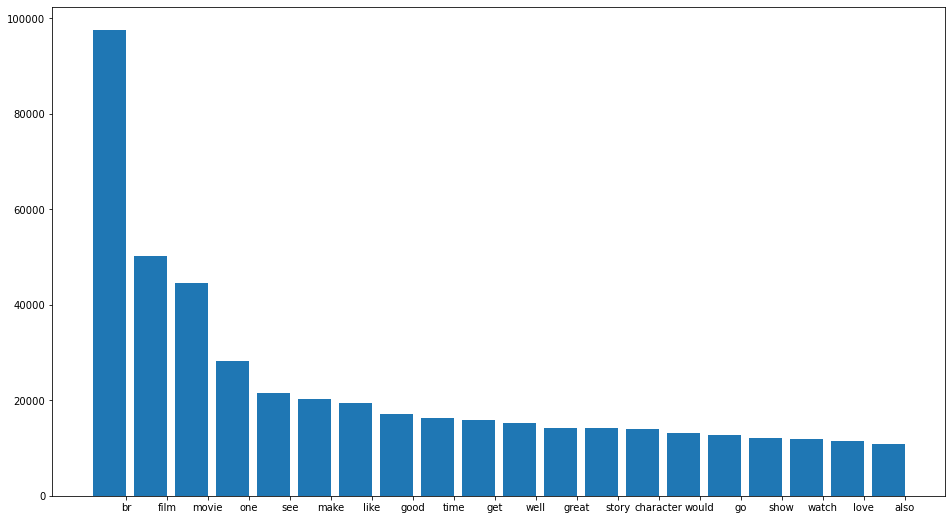

In [36]:
train_positive_sentiment = proc_dateset2[proc_dateset2.sentiment == 1]
positive_words = ' '.join(train_positive_sentiment['review'])
print("Top words in Positive Sentiment")
top_words(positive_words)

Top words in Negative Sentiment
[('br', 102806), ('movie', 57661), ('film', 44074), ('one', 26852), ('make', 23630), ('like', 23625), ('bad', 20622), ('see', 19304), ('get', 19127), ('would', 17878), ('good', 17359), ('even', 15196), ('time', 14996), ('go', 14968), ('character', 14120), ('watch', 13648), ('really', 12216), ('well', 11880), ('look', 11295), ('could', 11259)]


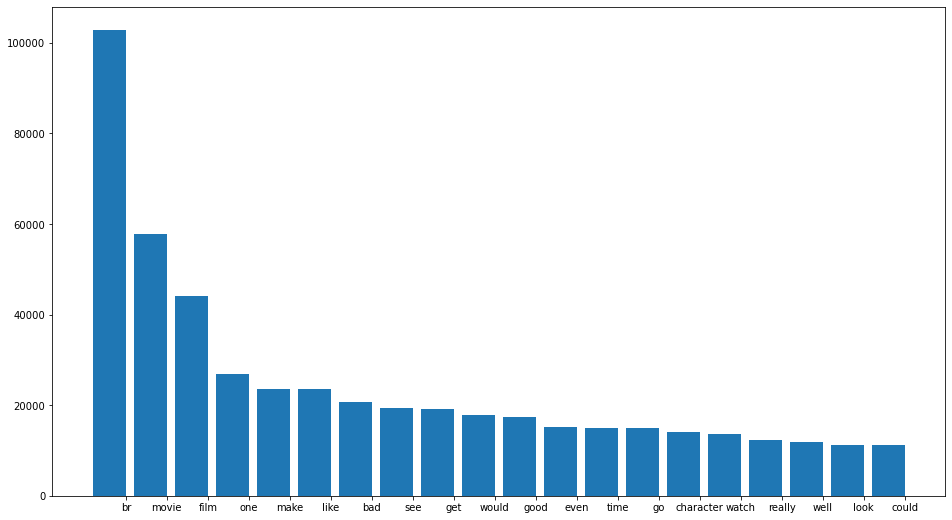

In [37]:
train_negative_sentiment = proc_dateset2[proc_dateset2.sentiment == 0]
negative_words = ' '.join(train_negative_sentiment['review'])
print("Top words in Negative Sentiment")
top_words(negative_words)

In [38]:
# Saving the dataframe
proc_dateset2.to_csv('Processes-dataset.csv')

**Read the processed dataset**

In [39]:
proc_dateset2 = pd.read_csv('Processes-dataset.csv')

proc_dateset2.drop(proc_dateset2.columns[0], axis=1, inplace=True)

proc_dateset2

,review,sentiment
0,one reviewer mention watch oz episode hook rig...,1
1,wonderful little production br br film techniq...,1
2,think wonderful way spend time hot summer week...,1
3,basically family little boy jake think zombie ...,0
4,petter mattei love time money visually stunnin...,1
...,...,...
49571,think movie right good job creative original f...,1
49572,bad plot bad dialogue bad acting idiotic direc...,0
49573,catholic teach parochial elementary school nun...,0
49574,go disagree previous comment side maltin one s...,0


In [40]:
proc_dateset3 = proc_dateset2.iloc[0:15000]
proc_dateset3

,review,sentiment
0,one reviewer mention watch oz episode hook rig...,1
1,wonderful little production br br film techniq...,1
2,think wonderful way spend time hot summer week...,1
3,basically family little boy jake think zombie ...,0
4,petter mattei love time money visually stunnin...,1
...,...,...
14995,never understood appeal garbo always come acro...,0
14996,entirely bad movie plot new house build next d...,0
14997,big md fan call like see film limp along plot ...,0
14998,pure crap probably bad biblical theme film eve...,0


**Split data to train, test and validate**

In [41]:
x, x_test, y, y_test = train_test_split(
    proc_dateset3['review'],
    proc_dateset3['sentiment'],
    test_size=0.2,
    random_state= 42
)

In [42]:
x_train, x_val, y_train, y_val = train_test_split(
    x,
    y,
    test_size=0.33,
    random_state= 42
)

**Get number of rows for each subset**

In [43]:
print(x_train.shape[0])
print(x_val.shape[0])
print(x_test.shape[0])

8040
3960
3000


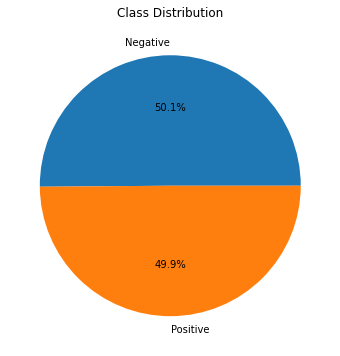

In [44]:
# Map the numerical labels to corresponding categories
classes = {0: 'Negative', 1: 'Positive'}

labels_description = np.array([classes[label] for label in y_train])

# Count the occurrences of each class in the 'labels_description' array
class_counts = np.unique(labels_description, return_counts=True)

# Create a pie chart
plt.figure(figsize=(10, 6))
plt.pie(class_counts[1], labels=class_counts[0], autopct='%1.1f%%')
plt.title('Class Distribution')
plt.show()

**Encode text using tfidf**

In [45]:
# Create the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the train data
tf_x_train = tfidf_vectorizer.fit_transform(x_train)

In [46]:
print('Number of features is:\n',tfidf_vectorizer.get_feature_names_out().shape)

Number of features is:
 (40574,)


In [47]:
# Transform validation and test data
tf_x_val = tfidf_vectorizer.transform(x_val)
tf_x_test = tfidf_vectorizer.transform(x_test)

In [48]:
tf_x_train = tf_x_train.toarray()
tf_x_val = tf_x_val.toarray()

## <font color='orange'> ***Train models***</font>

In [49]:
all_res = {
    'model':[],
    'acc_train':[],
    'acc_val':[]
}

In [50]:
def evaluate_model(model, x_train, y_train, x_val, y_val):
    model.fit(x_train, y_train)
    y_pred_train = model.predict(x_train)
    y_pred_val = model.predict(x_val)
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_val = accuracy_score(y_val, y_pred_val)
    return acc_train, acc_val

**Yahya's models**

In [60]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import CategoricalNB

# Ensemble learning
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier

In [ ]:
# Create individual Naive Bayes models
mnb = MultinomialNB()
bnb = BernoulliNB()
cnb = ComplementNB()

estimators=[
    ('multinomial', mnb),
    ('bernoulli', bnb),
    ('complement', cnb),
]

voting_clf = VotingClassifier(
    estimators,
    voting='soft'
)

In [63]:
all_estimators = estimators+[('voting clf', voting_clf)]

all_estimators

NameError: name 'estimators' is not defined

In [61]:
results = {
    'model':[],
    'acc_train':[],
    'acc_val':[]
}

for name, clf in all_estimators:
    acc_train, acc_val = evaluate_model(clf, tf_x_train,
               y_train, tf_x_val, y_val)
    results['model'].append(name)
    results['acc_train'].append(acc_train)
    results['acc_val'].append(acc_val)

NameError: name 'all_estimators' is not defined

In [ ]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='acc_val', ascending=False, ignore_index=True)

results_df

,model,acc_train,acc_val
0,voting clf,0.943408,0.854545
1,bernoulli,0.941294,0.854040
2,complement,0.934453,0.848990
3,multinomial,0.934328,0.848485


In [ ]:
bag_clf = BaggingClassifier(
    BernoulliNB(), n_estimators=100,
    max_samples=0.75, bootstrap= True, random_state=1, n_jobs=-1
)

In [ ]:
acc_train_bag, acc_val_bag = evaluate_model(bag_clf, tf_x_train,
               y_train, tf_x_val, y_val)

TerminatedWorkerError: ignored

**Fatma's models**

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import Perceptron
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier

In [ ]:
# Storing models in a list to loop through them
models_list = [
    LogisticRegression(penalty="l2",C=3,random_state=42,max_iter=1000),
    LogisticRegressionCV(max_iter=1000,cv=3),
    Perceptron(),
    RidgeClassifier(),
    SGDClassifier()
]

# creating a dictionary to store results
results_dict = {
    'model_name': [],
    'acc_train': [],
    'acc_val': [],
}

# for each model
for model in models_list:
    # evaluate the model and calculate acc_train and acc_val
    acc_train, acc_val = evaluate_model(
        model,
        tf_x_train,
        y_train,
        tf_x_val,
        y_val
    )

    # storing results in results_dict
    results_dict['model_name'].append(model.__class__.__name__)
    results_dict['acc_train'].append(acc_train)
    results_dict['acc_val'].append(acc_val)

    # Display model name with acc_train and acc_val
    print(model.__class__.__name__)
    print(acc_train, acc_val)
    print('--------------------------')


LogisticRegression
0.9730099502487563 0.8732323232323232
--------------------------
LogisticRegressionCV
0.970771144278607 0.8734848484848485
--------------------------
Perceptron
0.997636815920398 0.8558080808080808
--------------------------
RidgeClassifier
0.9895522388059701 0.8621212121212121
--------------------------
SGDClassifier
0.9800995024875622 0.8646464646464647
--------------------------


In [ ]:
# Storing models in a list to loop through them
models_list = [
    LogisticRegression(penalty="l2",C=3,random_state=42,max_iter=1000),
    LogisticRegression(penalty="l2",C=2,random_state=42,max_iter=1000),
    LogisticRegression(penalty="l2",C=2,random_state=42,max_iter=1000,multi_class="multinomial"),
]

# for each model
for model in models_list:
    # evaluate the model and calculate acc_train and acc_val
    acc_train, acc_val = evaluate_model(
        model,
        tf_x_train,
        y_train,
        tf_x_val,
        y_val
    )

    # storing results in results_dict
    results_dict['model_name'].append(model.__class__.__name__)
    results_dict['acc_train'].append(acc_train)
    results_dict['acc_val'].append(acc_val)

    # Display model name with acc_train and acc_val
    print(model.__class__.__name__)
    print(acc_train, acc_val)
    print('--------------------------')

LogisticRegression
0.9730099502487563 0.8732323232323232
--------------------------
LogisticRegression
0.96181592039801 0.8717171717171717
--------------------------
LogisticRegression
0.9809701492537314 0.871969696969697
--------------------------


In [ ]:
results_dict

{'model_name': ['LogisticRegression',
  'LogisticRegressionCV',
  'Perceptron',
  'RidgeClassifier',
  'SGDClassifier',
  'LogisticRegression',
  'LogisticRegression',
  'LogisticRegression'],
 'acc_train': [0.9730099502487563,
  0.970771144278607,
  0.997636815920398,
  0.9895522388059701,
  0.9800995024875622,
  0.9730099502487563,
  0.96181592039801,
  0.9809701492537314],
 'acc_val': [0.8732323232323232,
  0.8734848484848485,
  0.8558080808080808,
  0.8621212121212121,
  0.8646464646464647,
  0.8732323232323232,
  0.8717171717171717,
  0.871969696969697]}

**Taha's Models**


In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import NearestCentroid
from xgboost import XGBClassifier
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [55]:
C_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
acc_train_values = []
acc_val_values = []

for C in C_values:
    model = Pipeline([
        ('model', LogisticRegression(C=C, random_state=0))
    ])
    acc_train, acc_val = evaluate_model(model, tf_x_train, y_train, tf_x_val, y_val)
    acc_train_values.append(acc_train)
    acc_val_values.append(acc_val)

results = pd.DataFrame({
    'C': C_values,
    'acc_train': acc_train_values,
    'acc_val': acc_val_values
})

results

,C,acc_train,acc_val
0,0.0001,0.997015,0.836869
1,0.0010,0.999876,0.833333
2,0.0100,1.000000,0.832323
3,0.1000,1.000000,0.830051
4,1.0000,1.000000,0.828788
5,10.0000,1.000000,0.827778
6,100.0000,1.000000,0.827778
7,1000.0000,1.000000,0.825253
8,10000.0000,1.000000,0.820960


In [ ]:
LR = LogisticRegression(C=3.0, random_state=0)
acc_train, acc_val = evaluate_model(LR , tf_x_train, y_train, tf_x_val, y_val)
results['acc_train'].append(acc_train)
results['acc_val'].append(acc_val)
acc_train, acc_val

In [ ]:
rfc=RandomForestClassifier(n_jobs=3,class_weight='balanced')
acc_train, acc_val = evaluate_model(rfc , tf_x_train, y_train, tf_x_val, y_val)
results['model'].append('rfc')
results['acc_train'].append(acc_train)
results['acc_val'].append(acc_val)
acc_train, acc_val

(1.0, 0.8303030303030303)

In [ ]:
KNN = NearestCentroid(metric='euclidean')
acc_train, acc_val = evaluate_model(KNN , tf_x_train, y_train, tf_x_val, y_val)
results['model'].append('Knn')
results['acc_train'].append(acc_train)
results['acc_val'].append(acc_val)
acc_train, acc_val

(0.8034825870646766, 0.7838383838383839)

In [ ]:
XGB = XGBClassifier()
# XGB.fit(tf_x_train, y_train)
# y_pred=XGB.predict(tf_x_train)
# print(accuracy_score(y_train, y_pred))
acc_train, acc_val = evaluate_model(XGB , tf_x_train, y_train, tf_x_val, y_val)
results['model'].append('XGB')
results['acc_train'].append(acc_train)
results['acc_val'].append(acc_val)
acc_train, acc_val

(0.9829601990049751, 0.8272727272727273)

In [ ]:
S1 = svm.SVC()
# S1.fit(tf_x_train, y_train)
# y_pred=S1.predict(tf_x_train)
# print(accuracy_score(y_train, y_pred))
acc_train, acc_val = evaluate_model(XGB , tf_x_train, y_train, tf_x_val, y_val)
results['model'].append('SVC')
results['acc_train'].append(acc_train)
results['acc_val'].append(acc_val)

**Choosing best model**

In [ ]:
all_res = {
    'model':[],
    'acc_train':[],
    'acc_val':[]
}

all_res['model'] = results['model'] +  results_dict['model_name']
all_res['acc_train'] = results['acc_train'] + results_dict['acc_train']
all_res['acc_val'] = results['acc_val'] + results_dict['acc_val']

all_res

{'model': ['multinomial',
  'bernoulli',
  'complement',
  'voting clf',
  'LR',
  'rfc',
  'Knn',
  'XGB',
  'SVC',
  'LogisticRegression',
  'LogisticRegressionCV',
  'Perceptron',
  'RidgeClassifier',
  'SGDClassifier',
  'LogisticRegression',
  'LogisticRegression',
  'LogisticRegression'],
 'acc_train': [0.9343283582089552,
  0.9412935323383085,
  0.934452736318408,
  0.943407960199005,
  0.9953980099502487,
  1.0,
  0.8034825870646766,
  0.9829601990049751,
  0.9829601990049751,
  0.9730099502487563,
  0.970771144278607,
  0.997636815920398,
  0.9895522388059701,
  0.9800995024875622,
  0.9730099502487563,
  0.96181592039801,
  0.9809701492537314],
 'acc_val': [0.8484848484848485,
  0.854040404040404,
  0.848989898989899,
  0.8545454545454545,
  0.8656565656565657,
  0.8303030303030303,
  0.7838383838383839,
  0.8272727272727273,
  0.8272727272727273,
  0.8732323232323232,
  0.8734848484848485,
  0.8558080808080808,
  0.8621212121212121,
  0.8646464646464647,
  0.8732323232323232

In [ ]:
all_res_df = pd.DataFrame(all_res)

all_res_df = all_res_df.sort_values(by='acc_val', ascending=False, ignore_index=True)

all_res_df

,model,acc_train,acc_val
0,LogisticRegressionCV,0.970771,0.873485
1,LogisticRegression,0.973010,0.873232
2,LogisticRegression,0.973010,0.873232
3,LogisticRegression,0.980970,0.871970
4,LogisticRegression,0.961816,0.871717
5,LR,0.995398,0.865657
6,SGDClassifier,0.980100,0.864646
7,RidgeClassifier,0.989552,0.862121
8,Perceptron,0.997637,0.855808
9,voting clf,0.943408,0.854545


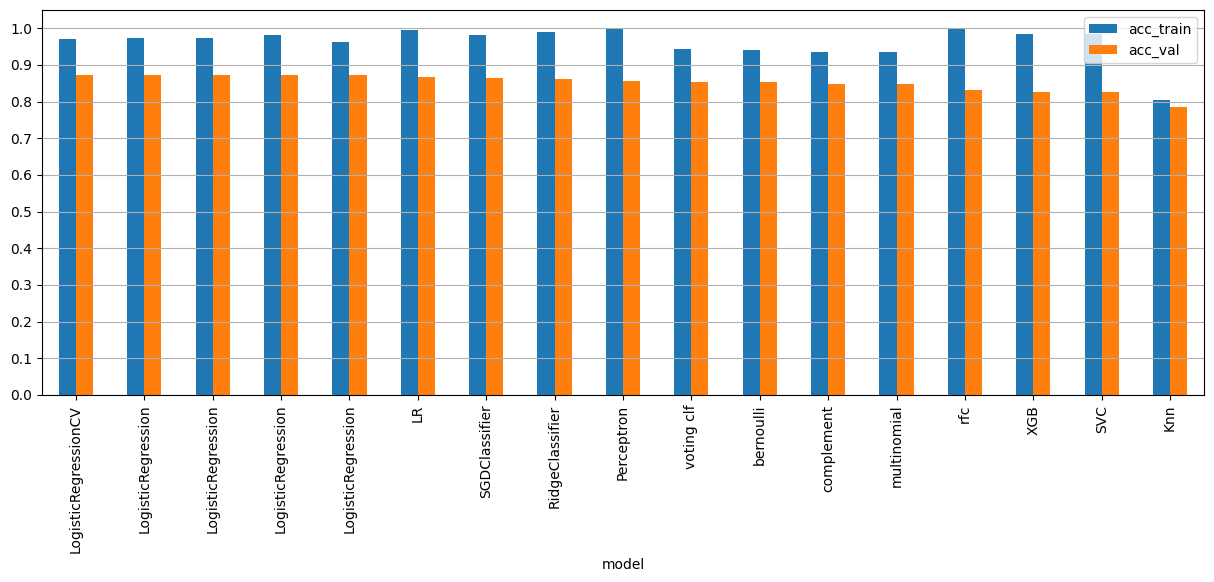

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

all_res_df.plot.bar(x='model',y=['acc_train', 'acc_val'], figsize=(15,5))
plt.yticks(np.arange(0.0, 1.1, 0.1))
plt.grid(axis='y')
plt.show()

**Saving best model**

In [ ]:
best_model =  LogisticRegressionCV(max_iter=1000,cv=3)
best_model.fit(tf_x_train, y_train)

LogisticRegressionCV(cv=3, max_iter=1000)

In [ ]:
# Saving model
with open('best-model.pickle', 'wb') as f:
    pickle.dump(best_model, f)

# Saving tfidf vectorizer
with open('tfidf_vectorizer.pickle', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

**Perform testing**

In [ ]:
# Predict y test
y_pred_test = best_model.predict(tf_x_test)

              precision    recall  f1-score   support

    Negative       0.90      0.86      0.88      1537
    Positive       0.86      0.90      0.88      1463

    accuracy                           0.88      3000
   macro avg       0.88      0.88      0.88      3000
weighted avg       0.88      0.88      0.88      3000



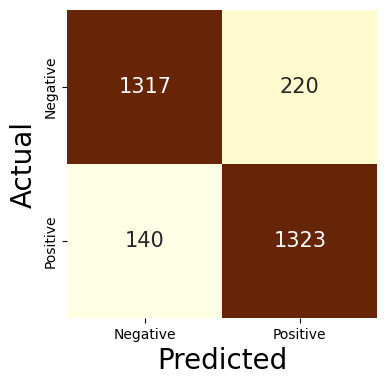

In [ ]:
target_names = ['Negative', 'Positive']
report = classification_report(y_test, y_pred_test, target_names=target_names, digits=2)
print(report)

disp = confusion_matrix(y_test, y_pred_test)
disp.astype('int')
pd.options.display.float_format='{:.5f}'.format
df_cm = pd.DataFrame(disp, target_names, target_names)
# plt.figure(figsize=(10,7))
fig, ax = plt.subplots(figsize=(4,4))
sn.set(font_scale=1.5) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size":15},ax=ax, cmap="YlOrBr", fmt='g',cbar=False) #font
plt.ylabel('Actual',fontsize=20)
plt.xlabel('Predicted',fontsize=20)
plt.ioff()
plt.savefig("confusion_mat", bbox_inches='tight')
plt.show()

**Test ensemble learning**

In [ ]:
import joblib
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from collections import Counter

In [ ]:
bnb_clf = BernoulliNB()

ds_clf = DecisionTreeClassifier(
    max_depth=29, random_state=0, min_samples_split=15, splitter='random',criterion='entropy'
)


lr_clf = LogisticRegression(
    C=3.0, random_state=0)

lrCV_clf = LogisticRegressionCV(max_iter=1000,cv=3)

r_clf = RidgeClassifier()

sgdc_clf = SGDClassifier()

In [ ]:
# Training models
bnb_clf.fit(tf_x_train, y_train)
ds_clf.fit(tf_x_train, y_train)
# Load the model from the file because its cmputayionally intensive
svc_clf = joblib.load('best_svc.pkl')
lr_clf.fit(tf_x_train, y_train)
lrCV_clf.fit(tf_x_train, y_train)
r_clf.fit(tf_x_train, y_train)
sgdc_clf.fit(tf_x_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator SVC from version 0.24.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


SGDClassifier()

In [ ]:
estimators=[
    ('BernoulliNB', bnb_clf),
    ('decisiontree', ds_clf),
    ('SVC', svc_clf),
    ('LogisticRegression', lr_clf),
    ('LogisticRegressionCV',lrCV_clf),
    ('ridge',r_clf),
    ('SGDC',sgdc_clf )
]

In [ ]:
def predict_voting(estimators, x):
  predictions_all = []

  for name, clf in estimators:
    y = clf.predict(x)
    predictions_all.append(y)

  predictions = []

  for p in range(len(predictions_all[0])):
    pred = []
    for i in range(len(estimators)):
      pred.append(predictions_all[i][p])

    # Use Counter to count the occurrences of each element
    counter = Counter(pred)
    # Use the max function with a custom key to find the most frequent element
    most_frequent_element = max(counter, key=counter.get)
    predictions.append(most_frequent_element)

  return predictions

**Training accuracy**

In [ ]:
y_pred_train = predict_voting(estimators, tf_x_train)

In [ ]:
accuracy_score(y_train, y_pred_train)

0.9818407960199005

**Validation accuracy**

In [ ]:
y_pred_val = predict_voting(estimators, tf_x_val)

In [ ]:
accuracy_score(y_val, y_pred_val)

0.878030303030303

**Test accuracy**

In [ ]:
y_pred_test = predict_voting(estimators, tf_x_test)

In [ ]:
accuracy_score(y_test, y_pred_test)

0.8846666666666667